## Pandas Dataset Path Handlers

Lightweight shortcuts for loading preprocessed SVD parquet files into pandas.  
Use `DATASETS.C128.k1.load()` or `DATASETS.C64.full.load()` to access the desired dataset without hard-coding paths.

- `DATASETS`: the `namespace` object that holds all dataset handles.
- `.C128`: selects the 128-component SVD family (maps to `../128Component/`). *Alternatively use `.C64` to load the 64-component SVD family*
- `.k1`: picks the 1k-run slice within that family (loads `1k.parquet`). *Alternatively use `.k10` to load the 10k-run slice, and `.full` to load the full dataset*

`.load()` turns the formed path into a loaded pandas DataFrame from the parquet

In [74]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import joblib

In [75]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [76]:
# Load the preprocessing pipeline
BASE_DIR = "/content/drive/MyDrive/STS-Win-Prediction"
preprocessor = joblib.load(f'{BASE_DIR}/Preprocessing/cleanup.joblib')

In [77]:
def train_test_split(df, test_size = 0.2, random_state = None):
  """A custom train_test_split implementation that ensures all samples from the same run stay together"""
  run_ids = df.run_id.unique()

  # Create a random state
  rng = np.random.default_rng(seed = random_state)

  # Shuffle the run_ids, shuffle is done this way to ensure entire runs stay together across the training and test dataset
  shuffled_ids = rng.permutation(run_ids)
  test_end = int(test_size * len(shuffled_ids)) + 1
  test_ids = shuffled_ids[:test_end]

  train_df = df[~df.run_id.isin(test_ids)]
  test_df = df[df.run_id.isin(test_ids)]

  return train_df, test_df

In [78]:
class _Dataset:
  def __init__(self, base_dir: str, dim: int, name: str):
    self.path = os.path.join(base_dir, f"{dim}Component", f"{name}.parquet")
  def load(self) -> pd.DataFrame:
    """Load the dataset into a pandas DataFrame"""
    return pd.read_parquet(self.path)
  def preprocess(self):
    df = self.load()
    processed = preprocessor.transform(df)
    feature_names = preprocessor.get_feature_names_out()
    # Clean the feature names by removing the trailing text generated by sklearn
    feature_names_cleaned = ['__'.join(f.split('__')[1:]) for f in feature_names]
    return pd.DataFrame(processed, columns = feature_names_cleaned, index = df.index)
  def get_train_and_test(self, test_size: int = 0.2, random_state: int = None):
    cleaned_df = self.preprocess()
    return train_test_split(cleaned_df, test_size, random_state)

class _Dim:
  def __init__(self, base_dir: str, dim: int):
    # aliases: k1 / _1k, k10 / _10k, full
    self.k1 = _Dataset(base_dir, dim, "1k")
    self._1k = self.k1
    self.k10 = _Dataset(base_dir, dim, "10k")
    self._10k = self.k10
    self.full = _Dataset(base_dir, dim, "full")

class DATASETS:
  dir = f'{BASE_DIR}/Datasets/SVD'
  C64 = _Dim(dir, 64)
  C128 = _Dim(dir, 128)

In [79]:
train_df, test_df = DATASETS.C128.k10.get_train_and_test(random_state = 42)

## Datasets and Data Loaders

In [80]:
# Turn the pandas dataframes into DataLoaders for less demanding use
import torch
from torch.utils.data import IterableDataset, DataLoader, Dataset
import pandas as pd
import pyarrow.parquet as pq

# DEPRECATED
class StsDataset(Dataset):
  """A pytorch dataset for creating dataloaders, partial fitting, and batched ML"""
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    """Get a tensor of run_data at a certain run_id"""
    if torch.is_tensor(idx):
      idx = idx.to_list()

    floor = self.df.iloc[idx]
    floor_X = torch.tensor(floor.drop('victory').values.astype('float32'), dtype = torch.float32)
    floor_Y = torch.tensor(floor.victory, dtype = torch.float32)

    if self.transform:
      floor_X = self.transform(floor_X)

    return floor_X, floor_Y

class GpuStsDataset(Dataset):
  """PyTorch dataset with GPU tensors pre-allocated for fast batching."""
  def __init__(self, df, device, transform = None):
    self.transform = transform
    self.device = device

    # Convert DataFrames to Tensors on the GPU ONCE during initialization. May be infeasible for full dataset
    X = df.drop(['victory', 'run_id'], axis = 1).values.astype('float32')
    y = df.victory.values.astype('float32')

    self.X = torch.tensor(X, dtype = torch.float32, device = device)
    self.y = torch.tensor(y, dtype = torch.float32, device = device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    """Get precomputed GPU tensors (no `.to(device)` needed)"""
    X_sample = self.X[idx]
    y_sample = self.y[idx]

    if self.transform:
      X_sample = self.transform(X_sample)

    return X_sample, y_sample

In [81]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


train_dataset_gpu = GpuStsDataset(train_df, device)
test_dataset_gpu = GpuStsDataset(test_df, device)

In [82]:
# Large batch size due to large input data
BATCH_SIZE = 4096
train_loader = DataLoader(train_dataset_gpu, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset_gpu, batch_size = BATCH_SIZE, shuffle = False)

## The `Trainer` class

We're going to be doing a lot of architecture exploration and training a few models with different infrastructures so we'll develop a nice framework for training and testing Pytorch neural networks to clean up our code later!

In [83]:
import matplotlib.pyplot as plt

class TrainingResults:
  def __init__(self, train_losses, val_losses, val_accuracies, best_epoch):
    self.train_losses = train_losses
    self.val_losses = val_losses
    self.val_accuracies = val_accuracies
    self.best_epoch = best_epoch
    self.epochs = [i + 1 for i in range(len(self.train_losses))]

  def plot_loss(self, title = None):
    plt.plot(self.epochs, self.train_losses, label = 'Training Loss')
    plt.plot(self.epochs, self.val_losses, label = 'Test Loss')
    plt.axvline(self.best_epoch, linestyle = '--', color = 'k', label = 'Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    if title is not None:
      plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

  def plot_acc(self, title = None):
    plt.plot(self.epochs, self.val_accuracies)
    plt.axvline(self.best_epoch, linestyle = '--', color = 'k', label = 'Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    if title is not None:
      plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [84]:
class BatchHandler:
  """Handles the possibility of different dimensionality and loss functions without changing `Trainer` code"""
  def __init__(self, criterion):
    self.criterion = criterion

  def forward_pass(self, model, batch_data):
    raise NotImplementedError

  def calculate_loss(self, batch_data, preds):
    """An overwritable way to calculate the loss"""
    y =  batch_data[1]
    return self.criterion(preds, y)

class Trainer:
  def __init__(self, model, optimizer, device, batch_handler, verbose=True):
    self.model = model
    self.optimizer = optimizer
    self.device = device
    self.verbose = verbose
    self.batch_handler = batch_handler

  def train_epoch(self, train_loader):
    self.model.train()
    running_loss = 0

    for batch in train_loader:
      # Get batch data safely despite potentially different spacing (LSTMS will return 3 elements, while standard NNs will return 2)
      self.optimizer.zero_grad()
      preds = self.batch_handler.forward_pass(self.model, batch)
      loss = self.batch_handler.calculate_loss(batch, preds)

      loss.backward()
      self.optimizer.step()
      running_loss += loss.item()

    return running_loss / len(train_loader)

  def evaluate(self, loader):
    self.model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for batch in loader:
        # Handle the forward pass in a way that doesn't inherently destructure the tuple
        preds = self.batch_handler.forward_pass(self.model, batch)
        # ASSUMPTION: The second element of the batch MUST be the y value
        y = batch[1]

        loss = self.batch_handler.calculate_loss(batch, preds)
        total_loss += loss.item()

        preds_binary = (preds > 0.5).float()
        correct += (preds_binary == y).sum().item()
        total += len(y)

    return total_loss / len(loader), correct / total

  def train_with_early_stopping(self, train_loader, val_loader,
                                epochs=100, patience=5):
    """Full training loop with early stopping"""
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    best_model_state = None

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
      if self.verbose:
        print(f'Beginning Training Epoch {epoch + 1}')
      train_loss = self.train_epoch(train_loader)
      val_loss, val_acc = self.evaluate(val_loader)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)

      if self.verbose:
        print(f"Epoch {epoch+1:3d} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

      # Early stopping logic
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = self.model.state_dict().copy()
        best_epoch = epoch + 1
        patience_counter = 0
      else:
        patience_counter += 1

      if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

    # Load best model
    if best_model_state is not None:
      self.model.load_state_dict(best_model_state)

    return TrainingResults(train_losses, val_losses, val_accuracies, best_epoch)

  # Stores predictions
  def predict(self, loader):
    self.model.eval()
    preds_list = []
    y_list = []

    with torch.no_grad():
      for batch in loader:
        preds = self.batch_handler.forward_pass(self.model, batch)
        y = batch[1]

        preds_list.append(preds.cpu())
        y_list.append(y.cpu())

    return torch.cat(y_list), torch.cat(preds_list)

In [85]:
# A traditional feed forward batch handler for traditional Neural Network Architectures
from torch.nn import BCELoss

class FeedforwardBatchHandler(BatchHandler):
  def forward_pass(self, model, batch_data):
    X, y = batch_data
    return model(X).squeeze()

criterion = BCELoss()
FF_Handler = FeedforwardBatchHandler(criterion)

## Modeling I: Logistic Regression

In [86]:
# Refactored logistic regression
from torch import nn
from torch.nn import BCELoss
from torch import optim

class LogisticRegression(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.linear = nn.Linear(input_dim, 1)

  def forward(self, x):
    x = self.linear(x)
    return torch.sigmoid(x)

# 157 dimensions in initial model
INPUT_DIM = 157
model = LogisticRegression(INPUT_DIM).to(device)
# Use binary cross-entropy loss
criterion = BCELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
LogisticRegressionTrainer = Trainer(model, optimizer, device, FF_Handler)

In [87]:
logistic_results = LogisticRegressionTrainer.train_with_early_stopping(
    train_loader,
    test_loader,
    epochs = 50,
    patience = 5
  )

Beginning Training Epoch 1
Epoch   1 | Train Loss: 1.1646 | Val Loss: 0.6643 | Val Acc: 0.7804
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.5198 | Val Loss: 0.4558 | Val Acc: 0.8100
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4515 | Val Loss: 0.4399 | Val Acc: 0.8220
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4336 | Val Loss: 0.4503 | Val Acc: 0.8269
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4214 | Val Loss: 0.4086 | Val Acc: 0.8288
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4207 | Val Loss: 0.4056 | Val Acc: 0.8303
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4239 | Val Loss: 0.5069 | Val Acc: 0.8282
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4118 | Val Loss: 0.4604 | Val Acc: 0.8277
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.4174 | Val Loss: 0.4528 | Val Acc: 0.8275
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.4129 | Val Loss: 0.4355 | Val Acc: 0.8283
Beginning Training Epoch 11
Epoch  11 | Train Los

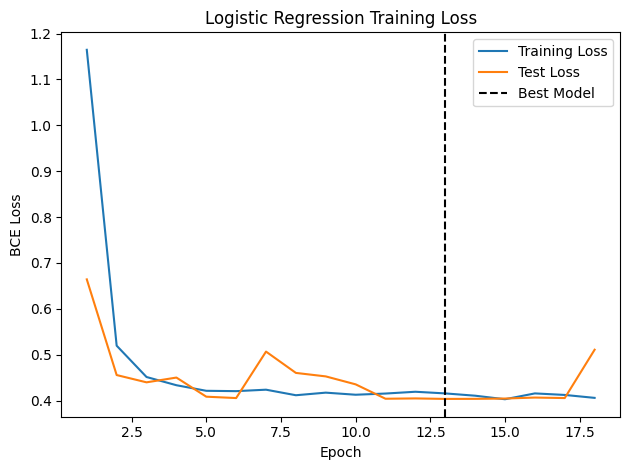

In [88]:
logistic_results.plot_loss("Logistic Regression Training Loss")

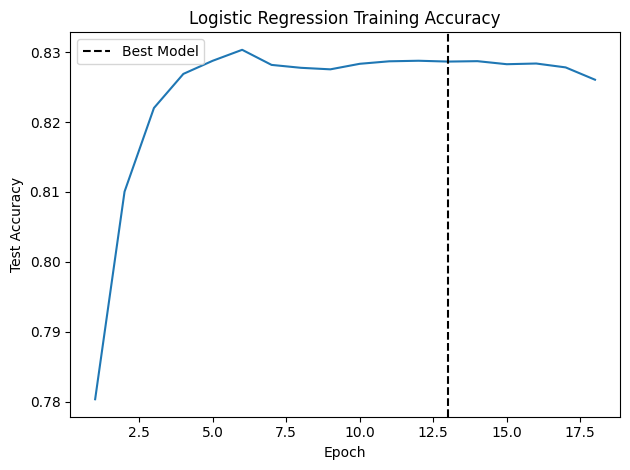

In [89]:
logistic_results.plot_acc('Logistic Regression Training Accuracy')

In [90]:
# TODO: Horizon-based custom accuracy function
#LogisticRegressionTrainer = Trainer(model, criterion, optimizer, device, FF_Handler)
#logistic_results = LogisticRegressionTrainer.train_with_early_stopping(train_loader,test_loader,epochs = 50,patience = 5)
hi, ho = LogisticRegressionTrainer.predict(test_loader)
print(hi)


tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [91]:
# A reusable archicecture to predict and plot a run
import seaborn as sns

class Predictor:
  """Makes prediction on a single run without using the DataLoaders"""

  def __init__(self, model, device):
    self.model = model
    self.device = device
    self.model.eval()

  def predict_with_confidence(self, df, threshold = 0.5):
    """Make predictions for a df with confidence scores"""
    ids = df.run_id
    floors = df.floor
    X = df.drop(['run_id', 'victory'], axis = 1).values.astype('float32')
    X_tensor = torch.tensor(X, dtype = torch.float32, device  = self.device)
    y = df.victory

    with torch.no_grad():
      probs = self.model(X_tensor).squeeze().cpu().numpy()

    predictions = (probs > threshold).astype('int')

    return pd.DataFrame({'prediction': predictions, 'probability': probs, 'victory': y, 'run_id': ids, 'floor': floors})

def plot_predictions(df, model_name: str, col_wrap = 4, height = 3.0, aspect = 1.0, sharey = False, sharex = False):
  """Plot the run-level win probability trajectory for a Predictor.predict_with_confidence() DataFrame"""
  order = (
          df.groupby("run_id")[['floor',"victory"]]
              .max()               # each run has a single victory value
              .sort_values(by = ['victory', 'floor'])         # Losing first, then sorted by run length
              .index
              .tolist()
      )
  g = sns.relplot(
        data=df,
        x="floor",
        y="probability",
        hue = 'victory',
        kind="line",
        col="run_id",
        col_wrap=col_wrap,
        col_order = order,
        height = height,
        aspect = aspect,
        facet_kws={"sharey": sharey, "sharex": sharex}
    )

  g.set(ylim = (0,1))
  g.set_axis_labels("Floor", "Predicted win prob")
  g.fig.suptitle(f"{model_name} Run-level win probability trajectories", y=1.02)
  g.fig.subplots_adjust(top=0.95)  # make space for the title
  plt.show()

In [92]:
# Runs at least 15 floors long should be interesting to visualize
long_runs = test_df[test_df.floor > 15]
winning_runs = long_runs[long_runs.victory].run_id.unique()
losing_runs = long_runs[~long_runs.run_id.isin(winning_runs)].run_id.unique()

N_SAMPLES = 4
samples = np.concatenate((winning_runs[:N_SAMPLES], losing_runs[:N_SAMPLES]))
sample = test_df[test_df.run_id.isin(samples)]

In [93]:
logistic_predictor = Predictor(model, device)
predictions = logistic_predictor.predict_with_confidence(sample)
predictions

,prediction,probability,victory,run_id,floor
156,0,0.121746,True,6,0
157,0,0.149941,True,6,1
158,0,0.145236,True,6,2
159,0,0.109707,True,6,3
160,0,0.125333,True,6,4
...,...,...,...,...,...
6403,1,0.863422,True,243,52
6404,1,0.631814,True,243,53
6405,1,0.697499,True,243,54
6406,1,0.720405,True,243,55


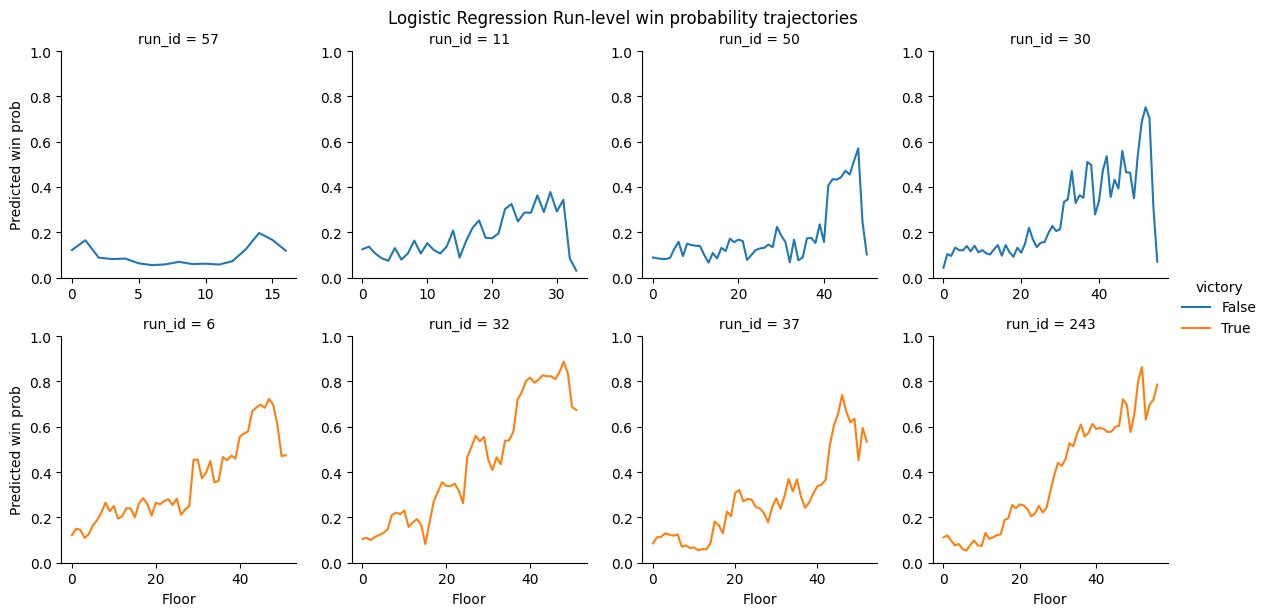

In [94]:
plot_predictions(predictions, model_name = 'Logistic Regression')

## Modeling II: Neural Network

### Setup

In [95]:
# TODO
class BasicNN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(input_dim, 64),
                             nn.ReLU(),
                             nn.Linear(64, 32),
                             nn.ReLU(),
                             nn.Linear(32, 1),
                             nn.Sigmoid())
  def forward(self, x):
      return self.net(x)


INPUT_DIM = 157
nn_model = BasicNN(INPUT_DIM).to(device)
criterion = BCELoss()
optimizer = optim.Adam(params = nn_model.parameters(), lr = 0.001)

In [96]:
NN_Trainer = Trainer(nn_model, optimizer, device, FF_Handler)

In [97]:
nn_results = NN_Trainer.train_with_early_stopping(
    train_loader,
    test_loader,
    epochs = 50,
    patience = 5
  )

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.6658 | Val Loss: 0.4409 | Val Acc: 0.8204
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.4347 | Val Loss: 0.4686 | Val Acc: 0.8314
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4260 | Val Loss: 0.4223 | Val Acc: 0.8337
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4136 | Val Loss: 0.4042 | Val Acc: 0.8355
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4063 | Val Loss: 0.4036 | Val Acc: 0.8332
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4001 | Val Loss: 0.4067 | Val Acc: 0.8327
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4126 | Val Loss: 0.5138 | Val Acc: 0.8301
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4116 | Val Loss: 0.4030 | Val Acc: 0.8332
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.4010 | Val Loss: 0.5120 | Val Acc: 0.8289
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.4006 | Val Loss: 0.3961 | Val Acc: 0.8323
Beginning Training Epoch 11
Epoch  11 | Train Los

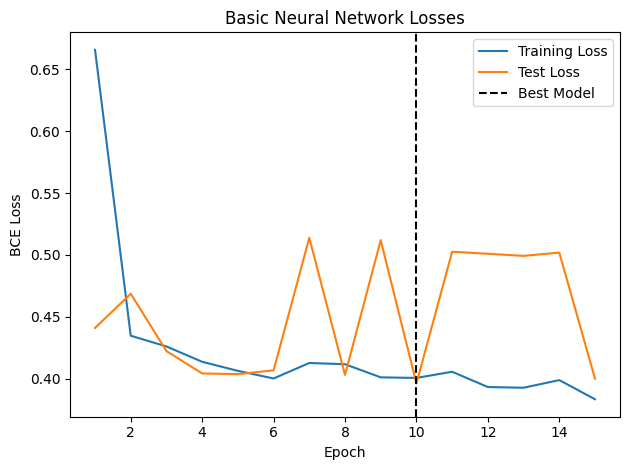

In [98]:
nn_results.plot_loss("Basic Neural Network Losses")

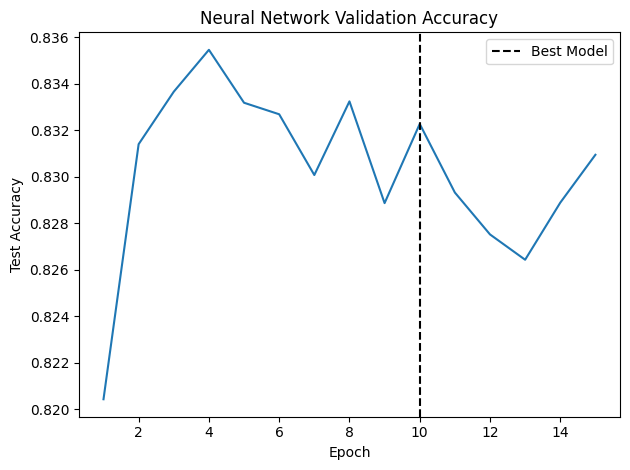

In [99]:
nn_results.plot_acc('Neural Network Validation Accuracy')

In [100]:
nn_predictor = Predictor(nn_model, device)
nn_predictions = nn_predictor.predict_with_confidence(sample)
nn_predictions

,prediction,probability,victory,run_id,floor
156,0,0.101718,True,6,0
157,0,0.124831,True,6,1
158,0,0.121116,True,6,2
159,0,0.106833,True,6,3
160,0,0.106540,True,6,4
...,...,...,...,...,...
6403,1,0.837641,True,243,52
6404,1,0.650653,True,243,53
6405,1,0.959099,True,243,54
6406,1,0.975624,True,243,55


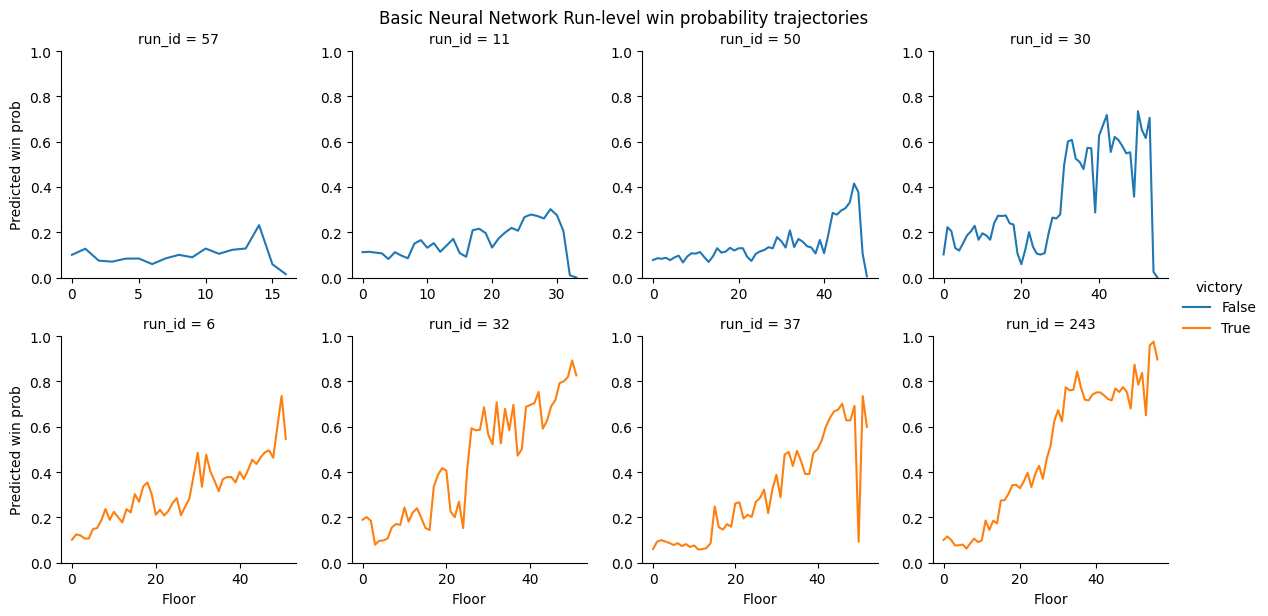

In [101]:
plot_predictions(nn_predictions, model_name = 'Basic Neural Network')

### NN Architecture 2: Dropout and Weight Decay

With a basic Neural Network architecture, the model is **highly variant**, so similar inputs lead to massive jumps, so despite higher overall accuracy our actual run-level predictions look much worse

We'll combat this using several methods of overfitting protection:
- `Skipping` to force linearity (Research more what this does)
- `Dropout` to fight overfitting and stabilize layer outputs

In [102]:
class DropoutNN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    H1_size = 128
    H2_size = 128

    self.fc1 = nn.Linear(input_dim, H1_size)
    self.dropout1 = nn.Dropout(0.3)

    self.fc2 = nn.Linear(H1_size, H2_size)
    self.dropout2 = nn.Dropout(0.25)

    self.fc3 = nn.Linear(H2_size, 1)

    self.act = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Hidden layer 1
    x = self.fc1(x)
    x = self.dropout1(x)
    x = self.act(x)

    x = self.fc2(x)
    x = self.dropout2(x)
    x = self.act(x)

    x = self.fc3(x)

    return self.sigmoid(x)

dropout_nn_model = DropoutNN(INPUT_DIM).to(device)
criterion = BCELoss()
# Also implement weight decay and regularization in the optimizer to incentivize stable model
optimizer = optim.Adam(params = dropout_nn_model.parameters(), lr = 0.001, weight_decay = 1e-4)

In [103]:
from torch.nn.modules.dropout import Dropout
dropout_nn_trainer = Trainer(dropout_nn_model, optimizer, device, FF_Handler)
dropout_nn_results = dropout_nn_trainer.train_with_early_stopping(train_loader, test_loader)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.5449 | Val Loss: 0.4200 | Val Acc: 0.8327
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.4597 | Val Loss: 0.4117 | Val Acc: 0.8338
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4536 | Val Loss: 0.3983 | Val Acc: 0.8353
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4375 | Val Loss: 0.4496 | Val Acc: 0.8342
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4201 | Val Loss: 0.4851 | Val Acc: 0.8337
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4127 | Val Loss: 0.4788 | Val Acc: 0.8339
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4117 | Val Loss: 0.3887 | Val Acc: 0.8357
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4033 | Val Loss: 0.3861 | Val Acc: 0.8359
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.3922 | Val Loss: 0.3957 | Val Acc: 0.8351
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.3878 | Val Loss: 0.4068 | Val Acc: 0.8339
Beginning Training Epoch 11
Epoch  11 | Train Los

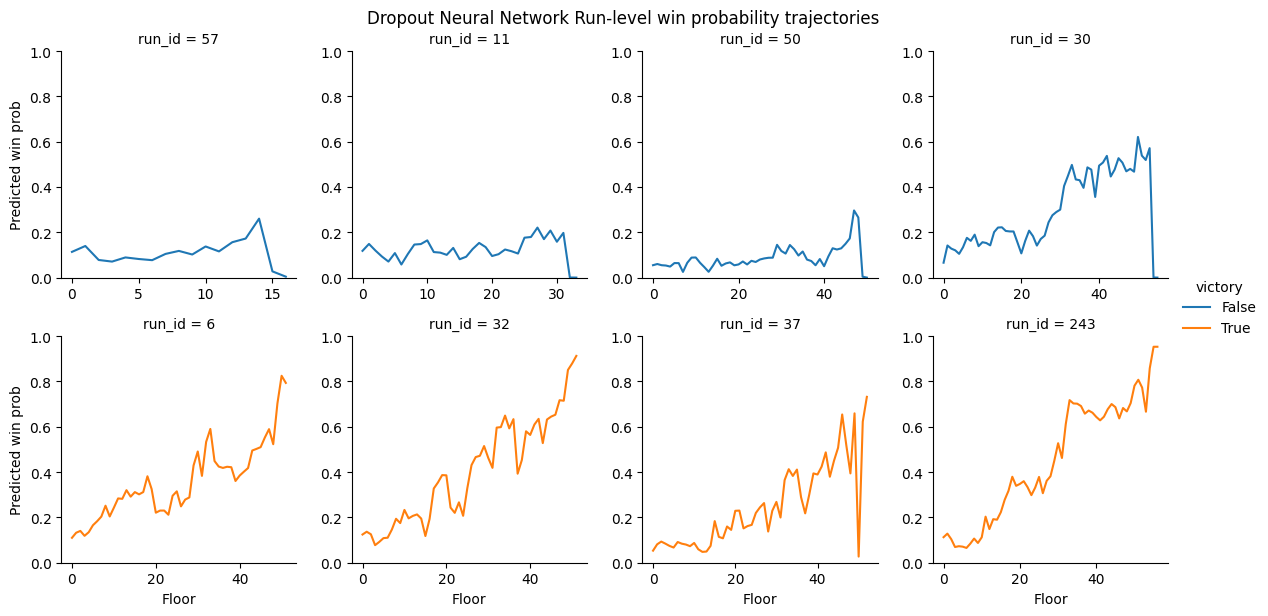

In [104]:
resistant_predictor = Predictor(dropout_nn_model, device)
resistant_predictions = resistant_predictor.predict_with_confidence(sample)
plot_predictions(resistant_predictions, 'Dropout Neural Network')

TODO: Reflect on why Dropout doesn't help stabilize the model (fighting weak signal problem, not strong)

### Architecture 3: Forcing Consistent outputs with a skipping layer

In [105]:
class SkippingNN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    H1_size = 128
    H2_size = 64

    self.fc1 = nn.Linear(input_dim, H1_size)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(H1_size, H2_size)
    self.dropout2 = nn.Dropout(0.5)

    self.skip = nn.Linear(input_dim, H2_size)
    self.fc3 = nn.Linear(H2_size, 1)

    self.act = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Hidden layer 1
    h = self.fc1(x)
    h = self.dropout1(h)
    h = self.act(h)

    h = self.fc2(h)
    h = self.dropout2(h)
    h = self.act(h)

    h = h + self.skip(x)
    h = self.fc3(h)

    return self.sigmoid(h)

skipping_nn_model = SkippingNN(INPUT_DIM).to(device)
criterion = BCELoss()
optimizer = optim.Adam(params = skipping_nn_model.parameters(), lr = 0.001, weight_decay = 1e-4)

In [106]:
skipping_nn_trainer = Trainer(skipping_nn_model, optimizer, device, FF_Handler)
skipping_nn_results = skipping_nn_trainer.train_with_early_stopping(train_loader, test_loader)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 1.2377 | Val Loss: 0.5246 | Val Acc: 0.8194
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.4935 | Val Loss: 0.4114 | Val Acc: 0.8270
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4395 | Val Loss: 0.4218 | Val Acc: 0.8270
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4323 | Val Loss: 0.4061 | Val Acc: 0.8300
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4218 | Val Loss: 0.4044 | Val Acc: 0.8295
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4269 | Val Loss: 0.4084 | Val Acc: 0.8298
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4125 | Val Loss: 0.4095 | Val Acc: 0.8285
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4177 | Val Loss: 0.4083 | Val Acc: 0.8294
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.4250 | Val Loss: 0.5102 | Val Acc: 0.8286
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.4153 | Val Loss: 0.3993 | Val Acc: 0.8310
Beginning Training Epoch 11
Epoch  11 | Train Los

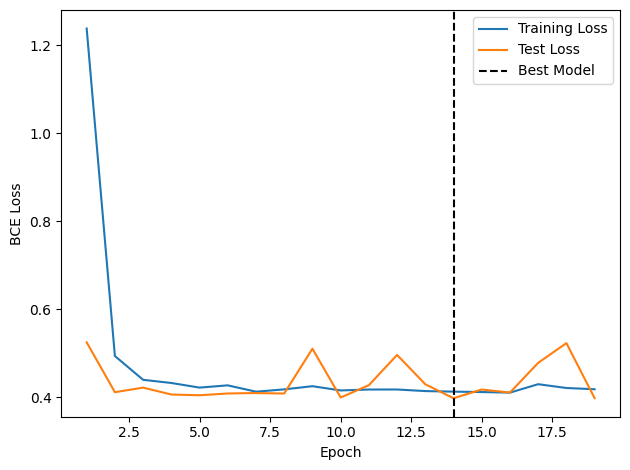

In [107]:
# Maybe batch size is too large - extremely volatile
skipping_nn_results.plot_loss()

In [108]:
skipping_nn_predictor =  Predictor(skipping_nn_model, device)
skipping_nn_predictions = skipping_nn_predictor.predict_with_confidence(sample)

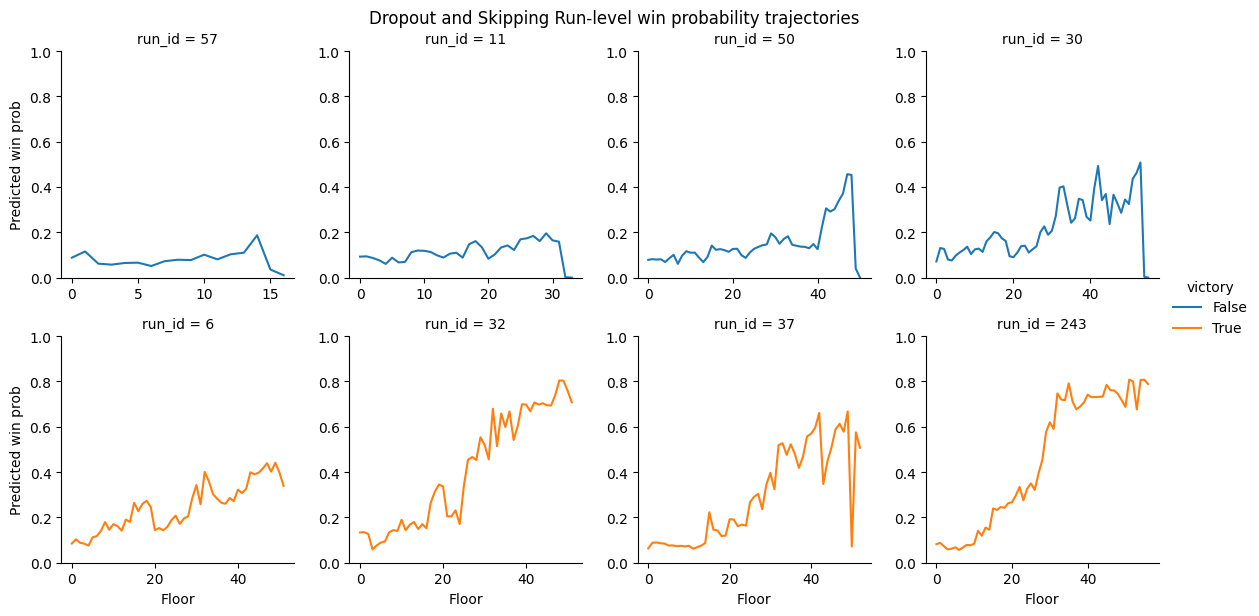

In [109]:
plot_predictions(skipping_nn_predictions, "Dropout and Skipping")

These minor architectural changes are clearly not stabilizing the model, maybe going with an LSTM or RNN based infrastructure is the correct approach!

## Modeling III: LSTMs and RNNs for stable predictors

Can we improve the model by giving individual records context of where they are in the run?

Write a longer Blurb about how many of the items will need rewrites to structure the code

In [110]:
class LstmStsDataset(Dataset):
  """Fast PyTorch dataset for LSTMs grouped by run_id"""
  def __init__(self, df, device, transform=None, min_seq_length=1):
    self.transform = transform
    self.device = device
    self.min_seq_length = min_seq_length

    # Sort once upfront
    df = df.sort_values(['run_id', 'floor']).reset_index(drop=True)

    # Get feature columns once
    feature_cols = df.drop(['victory', 'run_id'], axis=1).columns
    X_all = df[feature_cols].values.astype('float32')
    y_all = df['victory'].values.astype('float32')
    run_ids_all = df['run_id'].values

    # Find run boundaries (where run_id changes)
    # CITE: AI Usage on this difference line
    run_changes = np.concatenate([[0], np.where(np.diff(run_ids_all) != 0)[0] + 1, [len(run_ids_all)]])

    self.run_ids = df['run_id'].unique()
    self.run_data = {}

    # Group by boundaries instead of iterating
    for i in range(len(run_changes) - 1):
      start_idx = run_changes[i]
      end_idx = run_changes[i + 1]

      run_id = run_ids_all[start_idx]
      X_run = X_all[start_idx:end_idx]
      # Last value in run
      y_run = y_all[end_idx - 1]

      self.run_data[run_id] = {
        'X': torch.tensor(X_run, dtype=torch.float32, device=device),
        'y': torch.tensor(y_run, dtype=torch.float32, device=device),
        'length': len(X_run),
      }

  def __len__(self):
    return len(self.run_ids)

  def __getitem__(self, idx):
    run_id = self.run_ids[idx]
    X = self.run_data[run_id]['X']
    y = self.run_data[run_id]['y']
    max_len = self.run_data[run_id]['length']

    if max_len > self.min_seq_length:
      # IMPORTANT: Randomly truncate the sequence to force the model to learn continuous prediction
      # If this block is ommitted, the model gets really good at predicting at the end state, but is extremely volatile for mid-run predictions
      cutoff = torch.randint(self.min_seq_length, max_len + 1, (1,)).item()
      X = X[:cutoff]

    if self.transform:
      X = self.transform(X)

    return X, y, run_id

In [111]:
# Collation function for LSTM support (pad runs to be the same length)
def collate_sequences(batch):
  """
  Custom Collate function to handle variable-length sequences
  Pads sequences to the max length in the batch
  """

  sequences, targets, run_ids = zip(*batch)
  max_len = max(seq.shape[0] for seq in sequences)

  # Should be = INPUT_DIM
  batch_size = len(sequences)
  feature_dim = sequences[0].shape[1]

  padded_seqs = torch.zeros(batch_size, max_len, feature_dim, device = sequences[0].device, dtype = sequences[0].dtype)
  seq_lengths = []

  for i, seq in enumerate(sequences):
    seq_len = seq.shape[0]
    # Overwrite the padding with actual data
    padded_seqs[i, :seq_len, :] = seq
    seq_lengths.append(seq_len)

  targets = torch.stack(targets)
  seq_lengths = torch.tensor(seq_lengths)
  return padded_seqs, targets, seq_lengths

In [112]:
# Instantiate our new dataloaders
train_dataset_lstm = LstmStsDataset(train_df, device, min_seq_length = 2)
test_dataset_lstm = LstmStsDataset(test_df, device)

In [113]:
# Batch is now run level, not floor level so we'll use much smaller batches
BATCH_SIZE = 16

train_loader_lstm = DataLoader(train_dataset_lstm, BATCH_SIZE, shuffle = True, collate_fn = collate_sequences)
test_loader_lstm = DataLoader(test_dataset_lstm, BATCH_SIZE, shuffle = False, collate_fn = collate_sequences)

In [114]:
class LstmStsModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                        batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, X, seq_lengths):
    # Pack padded sequence
    packed = nn.utils.rnn.pack_padded_sequence(
      X, seq_lengths, batch_first=True, enforce_sorted=False
    )

    # LSTM Logic
    packed_out, (h_n, c_n) = self.lstm(packed)

    # Use final hidden state for prediction
    # Take last layer's hidden state
    out = self.fc(h_n[-1])
    return torch.sigmoid(out)

In [115]:
# SOMETHING BROKE WITH THIS REFACTOR, CERTAINTY IS REALLY LOW NOW
class LstmBatchHandler(BatchHandler):
  def forward_pass(self, model, batch_data):
    # Use this forward pass logic with 3 destructed elements
    X, y, seq = batch_data
    return model(X, seq.cpu()).squeeze(-1)

LSTM_Handler = LstmBatchHandler(criterion)

In [116]:
# Build and train LSTM model
lstm_model = LstmStsModel(INPUT_DIM, hidden_size = 128, num_layers = 2, dropout = 0.2).to(device)
optimizer = optim.Adam(params = lstm_model.parameters(), lr = 0.0005, weight_decay = 1e-4)
base_LstmTrainer = Trainer(lstm_model, optimizer, device, LSTM_Handler)
lstm_results = base_LstmTrainer.train_with_early_stopping(train_loader_lstm, test_loader_lstm)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.2685 | Val Loss: 0.2360 | Val Acc: 0.9175
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.2439 | Val Loss: 0.2413 | Val Acc: 0.9190
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.2304 | Val Loss: 0.2175 | Val Acc: 0.9205
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.2333 | Val Loss: 0.2358 | Val Acc: 0.9215
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.2294 | Val Loss: 0.2193 | Val Acc: 0.9210
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.2279 | Val Loss: 0.2318 | Val Acc: 0.9190
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.2327 | Val Loss: 0.2418 | Val Acc: 0.9110
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.2350 | Val Loss: 0.2359 | Val Acc: 0.9175
Early stopping triggered at epoch 8


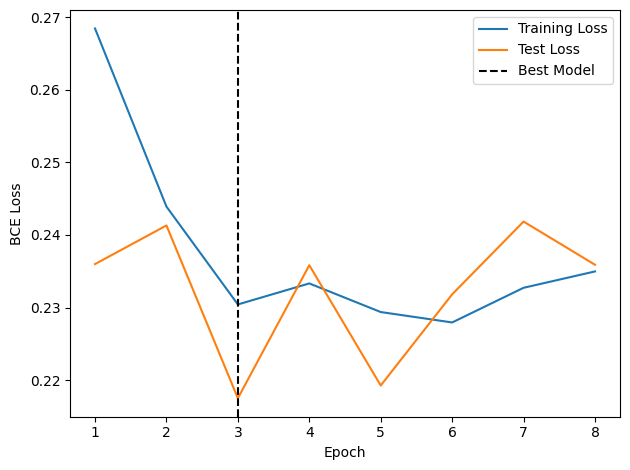

In [117]:
lstm_results.plot_loss()

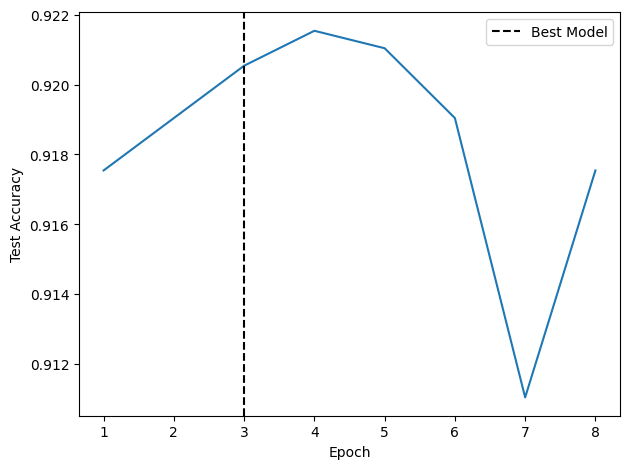

In [118]:
lstm_results.plot_acc()

In [144]:
# We also need to update the Predictor to handle the different shapes of the LSTM
class LstmPredictor:
  """Makes predictions on runs for LSTM models without using DataLoaders"""

  def __init__(self, model, device):
    self.model = model
    self.device = device
    self.model.eval()

  def predict(self, X_tensor, seq_length):
    return self.model(X_tensor, seq_length).squeeze().cpu().item()

  def predict_continuous(self, df, threshold=0.5):
    """Make continuous predictions at each step in a run"""
    run_id = df.run_id.iloc[0]
    run_df = df[df.run_id == run_id].sort_values('floor')

    X = run_df.drop(['run_id', 'victory'], axis=1).values.astype('float32')
    y = run_df['victory'].values
    floors = run_df['floor'].values

    predictions = []
    probabilities = []

    with torch.no_grad():
      # Make a prediction at each step using data up to that point
      for i in range(1, len(X) + 1):
        X_subset = X[:i]
        X_tensor = torch.tensor(X_subset, dtype=torch.float32, device=self.device).unsqueeze(0)
        seq_length = torch.tensor([len(X_subset)], dtype=torch.long)

        prob = self.predict(X_tensor, seq_length)
        pred = 1 if prob > threshold else 0

        predictions.append(pred)
        probabilities.append(prob)

    return pd.DataFrame({
      'floor': floors,
      'prediction': predictions,
      'probability': probabilities,
      'victory': y,
      'run_id': run_id
    })

  def predict_batch_continuous(self, df, threshold=0.5):
    """Make continuous predictions at each step for multiple runs"""
    results = []

    for run_id in df.run_id.unique():
      run_df = df[df.run_id == run_id]
      run_results = self.predict_continuous(run_df, threshold)
      results.append(run_results)

    return pd.concat(results, ignore_index=True)

In [145]:
lstm_predictor = LstmPredictor(lstm_model, device)
lstm_predictions = lstm_predictor.predict_batch_continuous(sample)

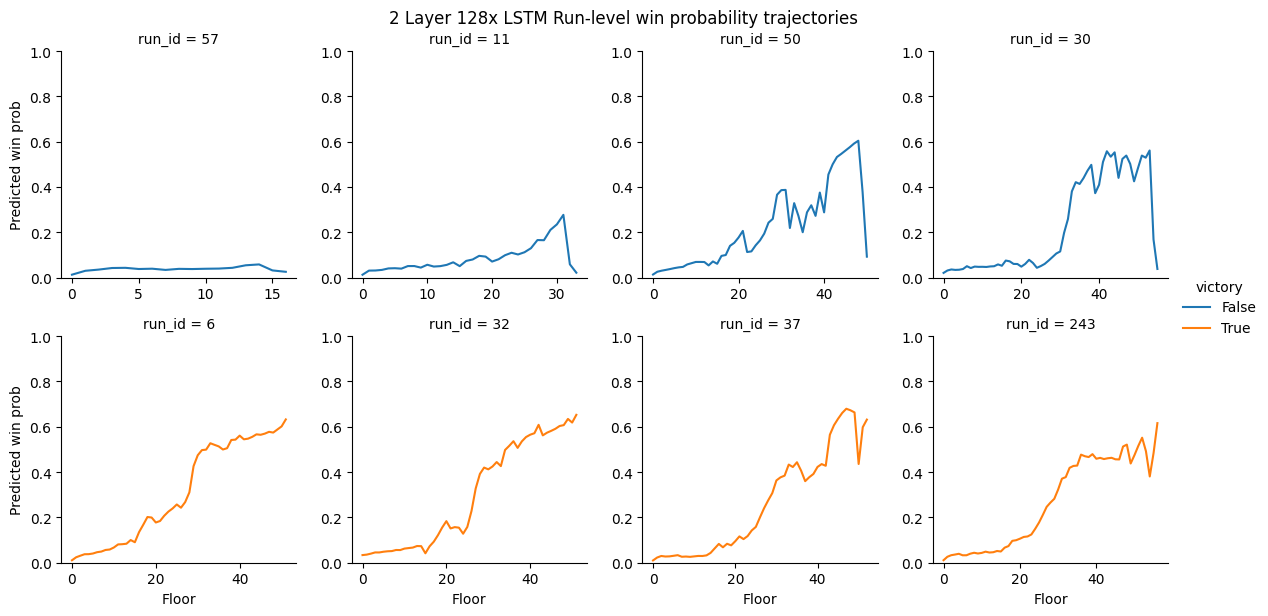

In [146]:
plot_predictions(lstm_predictions, '2 Layer 128x LSTM')

### LSTM Architecture Search

The model is now looking a **lot** less volatile, but it's still lacking confidence. We'll try the following to improve model confidence:

- More dropout to prevent overfitting
- Increasing the Number of Hidden Layers
- Integrating Custom Loss Functions for preferring early/late game predictions

In [122]:
# LSTM Architecture Search
# 3 layers, more dropout
lstm_model_3layer = LstmStsModel(INPUT_DIM, hidden_size = 128, num_layers = 3, dropout = 0.4).to(device)
optimizer = optim.Adam(params = lstm_model_3layer.parameters(), lr = 0.0005, weight_decay = 1e-4)
lstm_trainer_3layer = Trainer(lstm_model_3layer, optimizer, device, LSTM_Handler)
lstm_results_3layer = lstm_trainer_3layer.train_with_early_stopping(train_loader_lstm, test_loader_lstm)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.2841 | Val Loss: 0.2293 | Val Acc: 0.9205
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.2449 | Val Loss: 0.2359 | Val Acc: 0.9155
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.2469 | Val Loss: 0.2326 | Val Acc: 0.9180
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.2332 | Val Loss: 0.2283 | Val Acc: 0.9180
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.2382 | Val Loss: 0.2461 | Val Acc: 0.9135
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.2280 | Val Loss: 0.2288 | Val Acc: 0.9190
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.2288 | Val Loss: 0.2271 | Val Acc: 0.9175
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.2292 | Val Loss: 0.2359 | Val Acc: 0.9150
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.2376 | Val Loss: 0.2237 | Val Acc: 0.9200
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.2297 | Val Loss: 0.2194 | Val Acc: 0.9165
Beginning Training Epoch 11
Epoch  11 | Train Los

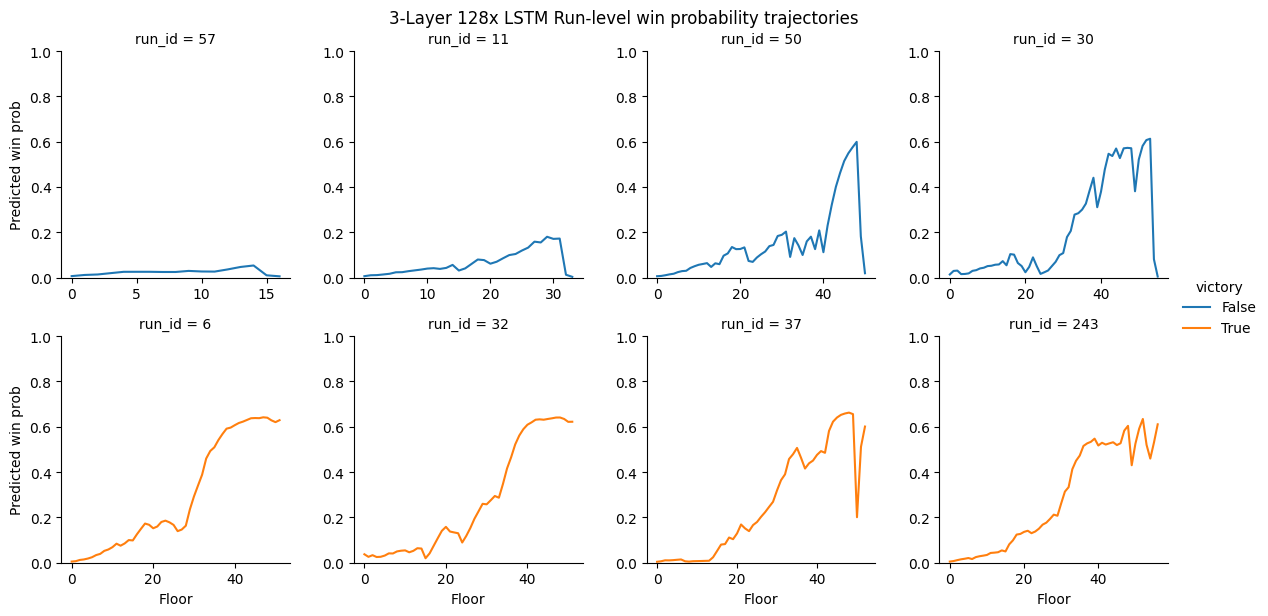

In [123]:
lstm_predictor_3layer = LstmPredictor(lstm_model_3layer, device)
lstm_predictions_3layer = lstm_predictor_3layer.predict_batch_continuous(sample)
plot_predictions(lstm_predictions_3layer, '3-Layer 128x LSTM')

**Messing Around with Horizon Weighted Loss**

In [151]:
class EarlyGameWeightedBCELoss(nn.Module):
    def __init__(self, early_weight = 1.5):
      super().__init__()
      self.bce = BCELoss(reduction = 'none')
      self.early_weight = early_weight

    def forward(self, preds, targets, seq_lengths = None):
      loss = self.bce(preds, targets).squeeze().cpu()
      if seq_lengths is not None:
        # Gentle weighting: early sequences get slight boost, not punishing late ones
        # Maps seq_lengths to weights between 1.0 and early_weight
        max_len = seq_lengths.float().max()
        normalized = seq_lengths.float() / max_len

        # Invert so early = high weight, late = low weight
        weights = 1.0 + (self.early_weight - 1.0) * (1.0 - normalized)

        loss = (loss.cpu() * weights).mean()
      else:
        loss = loss.mean()

      return loss

class CustomLossLstmBatchHandler(BatchHandler):
  def forward_pass(self, model, batch_data):
    # Use this forward pass logic with 3 destructed elements
    X, y, seq = batch_data
    return model(X, seq.cpu()).squeeze(-1)

  def calculate_loss(self, batch_data, preds):
    X, y, seq_len = batch_data
    return self.criterion(preds, y, seq_len)

weighted_criterion = EarlyGameWeightedBCELoss(early_weight = 3)
lstm_model_eg = LstmStsModel(INPUT_DIM, hidden_size = 128, num_layers = 2, dropout = 0.3).to(device)
lstm_handler_eg = CustomLossLstmBatchHandler(weighted_criterion)
optimizer = optim.Adam(params = lstm_model_eg.parameters(), lr = 0.0005, weight_decay = 1e-4)
lstm_trainer_eg = Trainer(lstm_model_eg, optimizer, device, lstm_handler_eg)
lstm_results_eg = lstm_trainer_eg.train_with_early_stopping(train_loader_lstm, test_loader_lstm)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.5350 | Val Loss: 0.4463 | Val Acc: 0.9175
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.4738 | Val Loss: 0.4957 | Val Acc: 0.9135
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4597 | Val Loss: 0.4912 | Val Acc: 0.9150
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4678 | Val Loss: 0.4377 | Val Acc: 0.9100
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4457 | Val Loss: 0.4624 | Val Acc: 0.9205
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4474 | Val Loss: 0.4110 | Val Acc: 0.9190
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4537 | Val Loss: 0.4776 | Val Acc: 0.9180
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4546 | Val Loss: 0.4378 | Val Acc: 0.9175
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.4391 | Val Loss: 0.4412 | Val Acc: 0.9200
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.4645 | Val Loss: 0.4363 | Val Acc: 0.9260
Beginning Training Epoch 11
Epoch  11 | Train Los

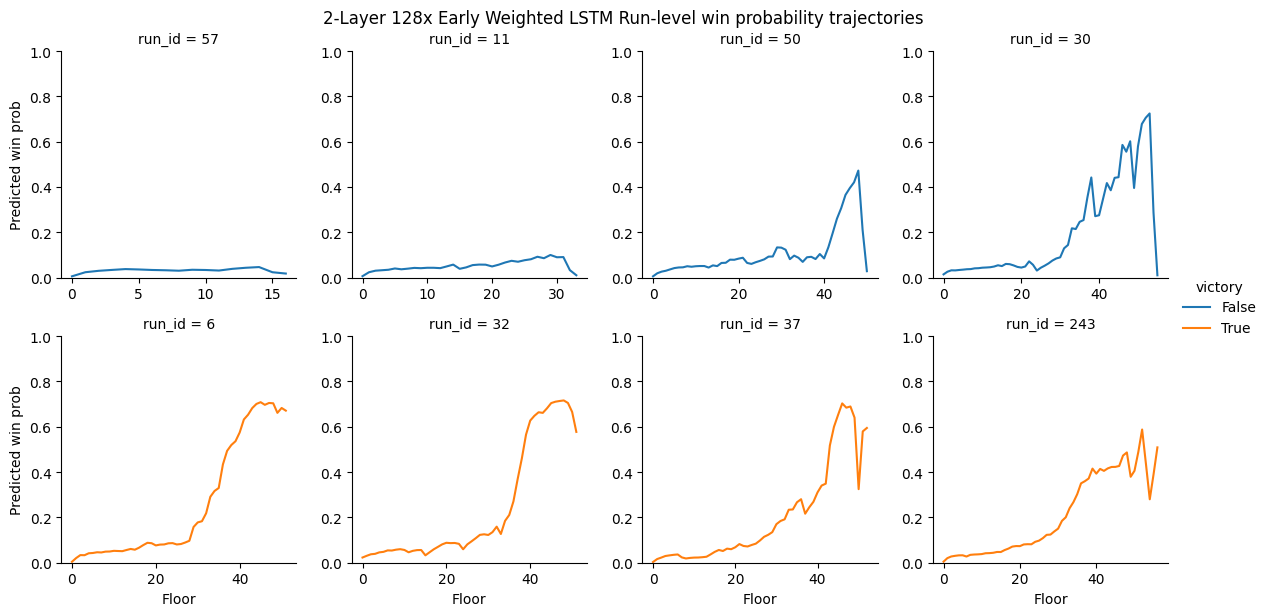

In [152]:
# NOTE: This and the late game predictions seems to be inverted to what we'd expect. Maybe the math in the predictor is wrong?
lstm_predictor_eg = LstmPredictor(lstm_model_eg, device)
lstm_predictions_eg = lstm_predictor_eg.predict_batch_continuous(sample)
plot_predictions(lstm_predictions_eg, '2-Layer 128x Early Weighted LSTM')

In [132]:
class LateGameWeightedBCELoss(nn.Module):
  def __init__(self, late_weight=1.5):
    super().__init__()
    self.bce = nn.BCELoss(reduction='none')
    self.late_weight = late_weight

  def forward(self, preds, targets, seq_lengths=None):
    loss = self.bce(preds, targets).squeeze()

    if seq_lengths is not None:
      # Weight later sequences more heavily
      max_len = seq_lengths.float().max()
      normalized = seq_lengths.float() / max_len

      # Don't invert - keep normalized as is so late = high weight
      weights = 1.0 + (self.late_weight - 1.0) * normalized

      loss = (loss.cpu() * weights).mean()
    else:
      loss = loss.mean()

    return loss

late_weighted_criterion = LateGameWeightedBCELoss(late_weight = 3)
lstm_model_lg = LstmStsModel(INPUT_DIM, hidden_size = 128, num_layers = 2, dropout = 0.3).to(device)
lstm_handler_lg = CustomLossLstmBatchHandler(late_weighted_criterion)
optimizer = optim.Adam(params = lstm_model_lg.parameters(), lr = 0.0005, weight_decay = 1e-4)
lstm_trainer_lg = Trainer(lstm_model_lg, optimizer, device, lstm_handler_lg)
lstm_results_lg = lstm_trainer_lg.train_with_early_stopping(train_loader_lstm, test_loader_lstm)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.5532 | Val Loss: 0.4759 | Val Acc: 0.9150
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.5107 | Val Loss: 0.4738 | Val Acc: 0.9165
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.4756 | Val Loss: 0.4811 | Val Acc: 0.9160
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.4681 | Val Loss: 0.4427 | Val Acc: 0.9175
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.4823 | Val Loss: 0.4473 | Val Acc: 0.9210
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.4735 | Val Loss: 0.4418 | Val Acc: 0.9145
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.4642 | Val Loss: 0.4407 | Val Acc: 0.9220
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.4795 | Val Loss: 0.4645 | Val Acc: 0.9185
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.4570 | Val Loss: 0.4505 | Val Acc: 0.9235
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.4642 | Val Loss: 0.4580 | Val Acc: 0.9185
Beginning Training Epoch 11
Epoch  11 | Train Los

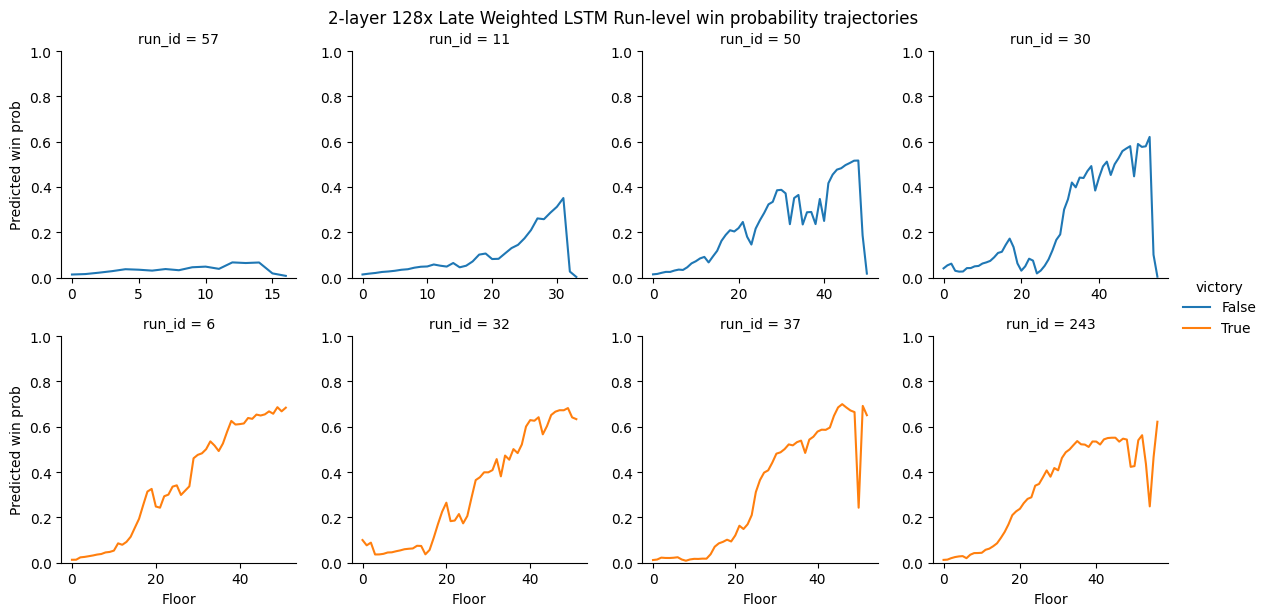

In [133]:
lstm_predictor_lg = LstmPredictor(lstm_model_lg, device)
lstm_prediction_lg = lstm_predictor_lg.predict_batch_continuous(sample)
plot_predictions(lstm_prediction_lg, '2-layer 128x Late Weighted LSTM')

## Modeling IV: Adding Attention

In [138]:
class LstmStsModelWithAttention(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                        batch_first=True, dropout=dropout)

    # Attention layer
    self.attention = nn.Sequential(
      nn.Linear(hidden_size, hidden_size // 2),
      nn.ReLU(),
      nn.Linear(hidden_size // 2, 1)
    )

    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, X, seq_lengths):
    # Pack padded sequence
    packed = nn.utils.rnn.pack_padded_sequence(
      X, seq_lengths, batch_first=True, enforce_sorted=False
    )

    # LSTM
    packed_out, (h_n, c_n) = self.lstm(packed)

    # Unpack to get full output sequence
    lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
      packed_out, batch_first=True
    )
    # lstm_out shape: (batch_size, max_seq_len, hidden_size)

    # Attention scores for each timestep
    attn_scores = self.attention(lstm_out)  # (batch_size, max_seq_len, 1)

    # Mask attention scores for padded positions
    # Create mask from seq_lengths (move seq_lengths to same device as lstm_out)
    seq_lengths_device = seq_lengths.to(lstm_out.device)

    # Calculates a mask to determine if each output layer is from padding or actual data
    mask = torch.arange(lstm_out.size(1), device=lstm_out.device).unsqueeze(0) < seq_lengths_device.unsqueeze(1)
    attn_scores = attn_scores.squeeze(-1)  # (batch_size, max_seq_len)
    # Fill all padding scores with -inf
    attn_scores = attn_scores.masked_fill(~mask, float('-inf'))

    # Softmax to get attention weights
    attn_weights = torch.softmax(attn_scores, dim=1)  # (batch_size, max_seq_len)

    # Weighted sum of LSTM outputs
    context = torch.bmm(attn_weights.unsqueeze(1), lstm_out)  # (batch_size, 1, hidden_size)
    context = context.squeeze(1)  # (batch_size, hidden_size)

    # Final prediction
    out = self.fc(context)
    return torch.sigmoid(out), attn_weights

  def get_attention_weights(self, X, seq_lengths):
    """Get attention weights for interpretability (eval bar)"""
    _, attn_weights = self.forward(X, seq_lengths)
    return attn_weights

class LstmAttentionBatchHandler(BatchHandler):
  def forward_pass(self, model, batch_data):
    X, y, seq = batch_data
    preds, attn_weights = model(X, seq.cpu())
    return preds.squeeze(-1)

LstmAttnHandler = LstmAttentionBatchHandler(BCELoss())

In [139]:
lstm_attn_model = LstmStsModelWithAttention(INPUT_DIM, hidden_size = 128, num_layers = 2, dropout = 0.2).to(device)
optimizer = optim.Adam(params = lstm_attn_model.parameters(), lr= 0.0005, weight_decay = 1e-4)
lstm_attn_trainer = Trainer(lstm_attn_model, optimizer, device, LstmAttnHandler)
lstm_attn_results = lstm_attn_trainer.train_with_early_stopping(train_loader_lstm, test_loader_lstm)

Beginning Training Epoch 1
Epoch   1 | Train Loss: 0.2775 | Val Loss: 0.2380 | Val Acc: 0.9135
Beginning Training Epoch 2
Epoch   2 | Train Loss: 0.2449 | Val Loss: 0.2253 | Val Acc: 0.9155
Beginning Training Epoch 3
Epoch   3 | Train Loss: 0.2450 | Val Loss: 0.2528 | Val Acc: 0.9150
Beginning Training Epoch 4
Epoch   4 | Train Loss: 0.2471 | Val Loss: 0.2393 | Val Acc: 0.9190
Beginning Training Epoch 5
Epoch   5 | Train Loss: 0.2422 | Val Loss: 0.2306 | Val Acc: 0.9185
Beginning Training Epoch 6
Epoch   6 | Train Loss: 0.2389 | Val Loss: 0.2247 | Val Acc: 0.9185
Beginning Training Epoch 7
Epoch   7 | Train Loss: 0.2443 | Val Loss: 0.2421 | Val Acc: 0.9170
Beginning Training Epoch 8
Epoch   8 | Train Loss: 0.2425 | Val Loss: 0.2383 | Val Acc: 0.9210
Beginning Training Epoch 9
Epoch   9 | Train Loss: 0.2303 | Val Loss: 0.2508 | Val Acc: 0.8981
Beginning Training Epoch 10
Epoch  10 | Train Loss: 0.2288 | Val Loss: 0.2246 | Val Acc: 0.9165
Beginning Training Epoch 11
Epoch  11 | Train Los

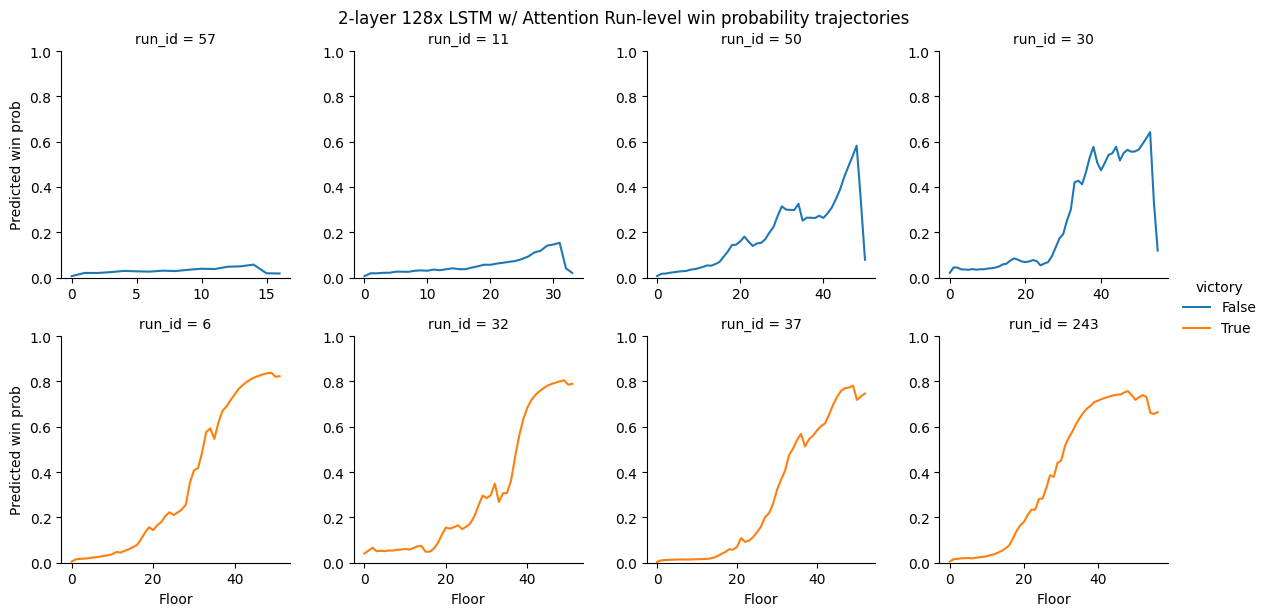

In [149]:
class LstmAttnPredictor(LstmPredictor):
  """Handle self.model() output size difference for attention vector"""
  def predict(self, X_tensor, seq_len):
    pred, attn = self.model(X_tensor, seq_len)
    return pred.squeeze().cpu().item()

lstm_attn_predictor = LstmAttnPredictor(lstm_attn_model, device)
lstm_attn_predictions = lstm_attn_predictor.predict_batch_continuous(sample)
plot_predictions(lstm_attn_predictions, "2-layer 128x LSTM w/ Attention")

# Final LSTM Model: Win Prediction with Attention

## Overview

We've successfully built an LSTM-based model that predicts Slay the Spire run outcomes with high accuracy and interpretability. The model processes game state sequentially (floor by floor) and learns to identify key decision points that influence victory or defeat.

## Architecture

The model consists of three main components:

### 1. **LSTM Encoder** (2 layers, 128 hidden units)

- Processes the run sequentially, building context from each floor's game state
- Maintains long-term dependencies across the run
- Outputs hidden states for each timestep

### 2. **Attention Mechanism**

- Learns which floors are most important for predicting outcomes
- Scores each timestep independently through a small neural network
- Produces normalized attention weights that sum to 1
- Creates a weighted context vector from the most relevant floors

### 3. **Prediction Head**

- akes the attention-weighted context
- Produces a single probability via sigmoid activation
- Represents the model's confidence in a run's success

## Performance

- **Validation Accuracy:** ~92%
- **Prediction Smoothness:** Clean, monotonic trajectories that reflect game progression
- **Interpretability:** Attention weights reveal which floors influenced each prediction
- **Separation:** Clear visual separation between winning (orange) and losing (blue) runs by mid-game

## Key Insights

- Early floors (1-15) provide limited signal; predictions are appropriately uncertain
- Mid-game (floors 15-35) shows rapid confidence building as run viability becomes clearer
- Late game (35+) predictions are stable and confident, with occasional sharp reversals when runs deteriorate

The model successfully learns that certain game states are insurmountable (sudden drops to 0 or 1)